In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 25})

In [6]:
PSP_kappa_data = np.load('/data/mjy/Yeqiang/sub_threshold_single_kappa.npz')
singlev = torch.tensor(PSP_kappa_data['singlev'][:, ::10], dtype=torch.float32) + 70
kappa = PSP_kappa_data['kappa']

In [76]:
# 定义初始参数
tau_rise = torch.tensor([34.8346, 27.0583, 39.7960, 44.3189], dtype=torch.float32, requires_grad=True)
tau_decay = torch.tensor([31.8350, 33.8176, 30.8849, 32.9315], dtype=torch.float32, requires_grad=True)
omega = torch.tensor([3.7309,  4.0776,  2.7823,  4.6054], dtype=torch.float32, requires_grad=True)

# 定义时间步长
time_dur = singlev.shape[1]  # singlev 的 shape (N, time_dur)
T = torch.arange(time_dur, dtype=torch.float32).unsqueeze(0)  # (1, time_dur)

# 定义优化器
optimizer = optim.Adam([tau_rise, tau_decay, omega], lr=0.01)

# 训练循环
num_epochs = 10000
loss_fn = nn.MSELoss()

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # 计算 kernels
    net_tau_rise = tau_rise.unsqueeze(1)  # (N, 1)
    net_tau_decay = tau_decay.unsqueeze(1)  # (N, 1)
    net_omega = omega.unsqueeze(1)  # (N, 1)

    kernels = net_omega * (1 - torch.exp(-T / net_tau_rise)) * torch.exp(-T / net_tau_decay)

    # 计算损失
    loss = loss_fn(kernels, singlev[2:6])

    # 反向传播并更新参数
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

print(f'Final Loss: {loss.item()}')


Epoch 0, Loss: 0.00036876380909234285
Epoch 1000, Loss: 0.00026201255968771875
Epoch 2000, Loss: 0.0002590676594991237
Epoch 3000, Loss: 0.0002560298889875412
Epoch 4000, Loss: 0.0002543549635447562
Epoch 5000, Loss: 0.00025408511282876134
Epoch 6000, Loss: 0.00025395789998583496
Epoch 7000, Loss: 0.0002538689586799592
Epoch 8000, Loss: 0.0002538062399253249
Epoch 9000, Loss: 0.0002537609252613038
Final Loss: 0.0002537286200094968


In [77]:
print('tau_rise:', tau_rise), print('tau_decay:', tau_decay), print('omega:', omega)

tau_rise: tensor([23.3248, 24.8767, 27.9595, 92.0559], requires_grad=True)
tau_decay: tensor([35.1116, 34.7575, 34.1037, 28.8401], requires_grad=True)
omega: tensor([2.4990, 3.7970, 2.0292, 9.3066], requires_grad=True)


(None, None, None)

In [86]:
tau_rise = torch.tensor([14.1240, 15.0063, 23.3249, 24.8767, 27.9599, 92.0559, 10.9722, 11.7295,
        14.2911], dtype=torch.float32)
tau_decay = torch.tensor([37.7183, 37.4177, 35.1115, 34.7575, 34.1032, 28.8401, 39.7667, 39.4985,
        38.4934], dtype=torch.float32)
omega = torch.tensor([ 4.4187,  3.4108,  2.5590, 3.8970, 2.1292, 9.6566, -2.2645, -2.6854,
        -2.3666], dtype=torch.float32)
net_tau_rise = tau_rise.unsqueeze(1)  # (N, 1)
net_tau_decay = tau_decay.unsqueeze(1)  # (N, 1)
net_omega = omega.unsqueeze(1)  # (N, 1)

kernels = net_omega * (1 - torch.exp(-T / net_tau_rise)) * torch.exp(-T / net_tau_decay)


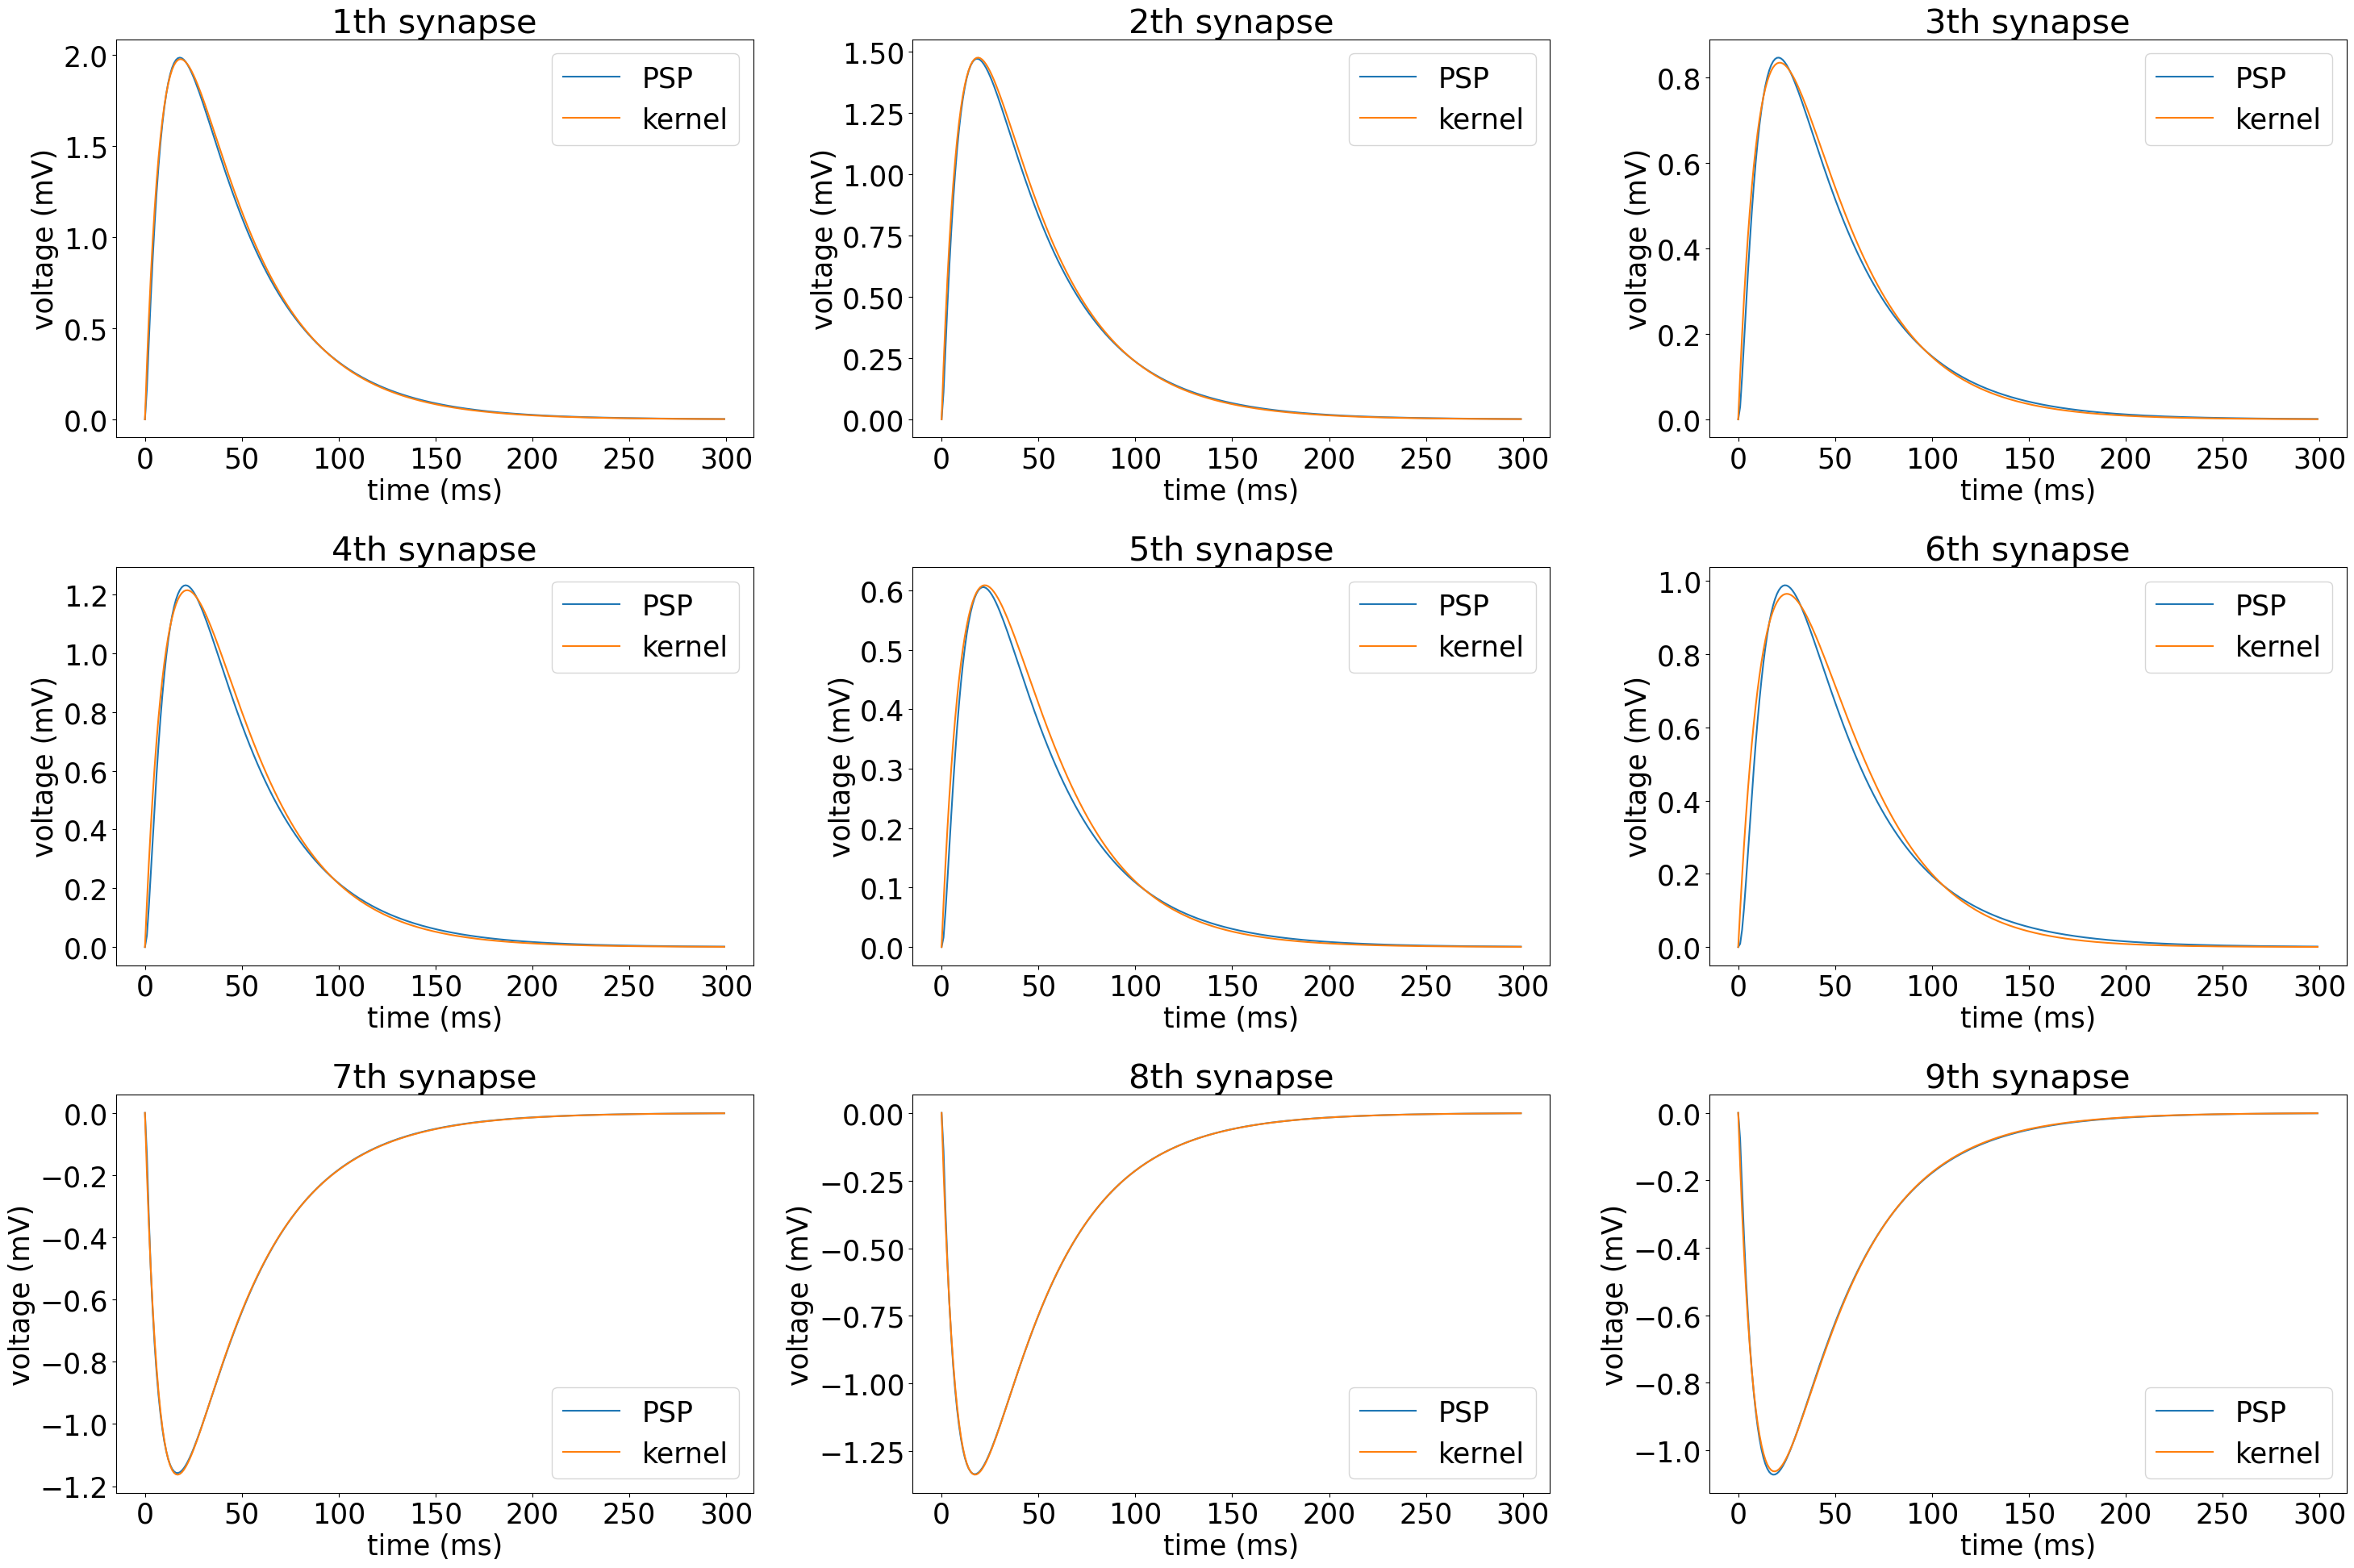

In [87]:
# 创建 4x4 的子图网格
fig, axs = plt.subplots(3, 3, figsize=(30, 20))

for i in range(9):
    row = i // 3  # 计算当前图像的行号
    col = i % 3   # 计算当前图像的列号
    ax = axs[row, col]
    
    # 绘制每个子图的内容
    ax.plot(singlev[i].numpy()[:300], label='PSP')
    ax.plot(kernels[i].detach().numpy()[:300], label='kernel')
    ax.set_title(f'{i+1}th synapse')
    ax.set_xlabel('time (ms)')
    ax.set_ylabel('voltage (mV)')
    ax.legend()

# 调整子图之间的间距
plt.tight_layout()

# 保存整个大图
# plt.savefig('/home/mjy/project/jaxley/cerebellum/grc09/figures/combined_train_na_para3.png')
plt.show()